In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Swain vs. Alabama ##

In [3]:
population_proportions = make_array(.26, .74)
population_proportions

array([ 0.26,  0.74])

In [6]:
sample_proportions(100, population_proportions)

array([ 0.23,  0.77])

In [7]:
def panel_proportion():
    return sample_proportions(100, population_proportions).item(0)

In [8]:
panel_proportion()

0.23

In [9]:
panels = make_array()

num_simulations = 10000

for i in np.arange(num_simulations):
    new_panel = panel_proportion() * 100
    panels = np.append(panels, new_panel)

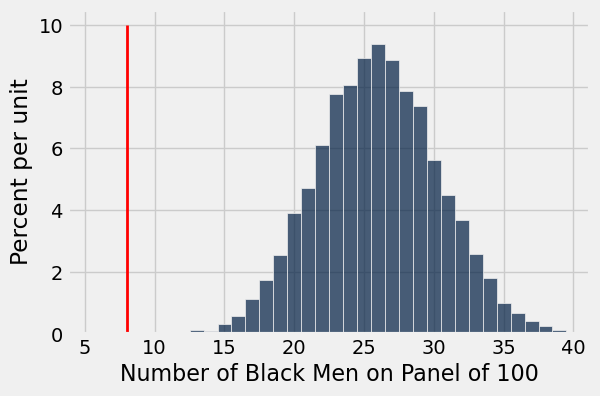

In [10]:
Table().with_column('Number of Black Men on Panel of 100', panels).hist(bins=np.arange(5.5,40.))
plots.plot([8, 8], [0, .1], color='red', lw=2);

In [11]:
np.count_nonzero(panels <= 8) / num_simulations

0.0

## Alameda County Jury Panels ##

In [12]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


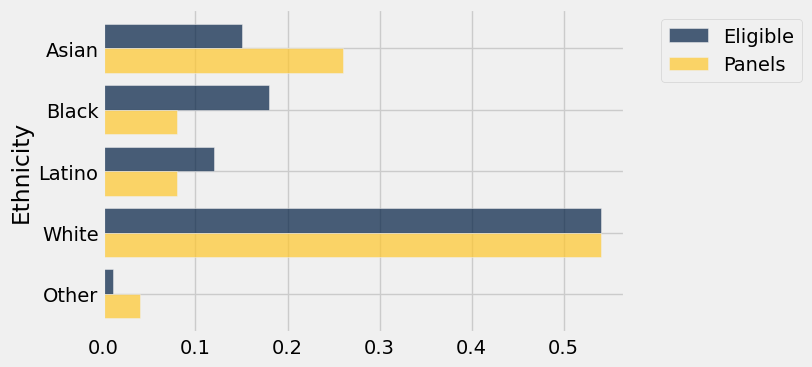

In [13]:
jury.barh('Ethnicity')

In [14]:
# Under the model, this is the true distribution of people
# from which the jurors are randomly sampled
model = jury.column('Eligible')
model

array([ 0.15,  0.18,  0.12,  0.54,  0.01])

In [20]:
# Let's simulate a random draw of 1423 jurors from this distribution
simulated = sample_proportions(1423, model)
simulated

array([ 0.14827829,  0.18200984,  0.11595221,  0.54181307,  0.01194659])

In [21]:
# The actual observed distribution (Panels) looks quite different
# from the simulation -- try running this several times to confirm!
jury_with_simulated = jury.with_column('Simulated', simulated)
jury_with_simulated

Ethnicity,Eligible,Panels,Simulated
Asian,0.15,0.26,0.148278
Black,0.18,0.08,0.18201
Latino,0.12,0.08,0.115952
White,0.54,0.54,0.541813
Other,0.01,0.04,0.0119466


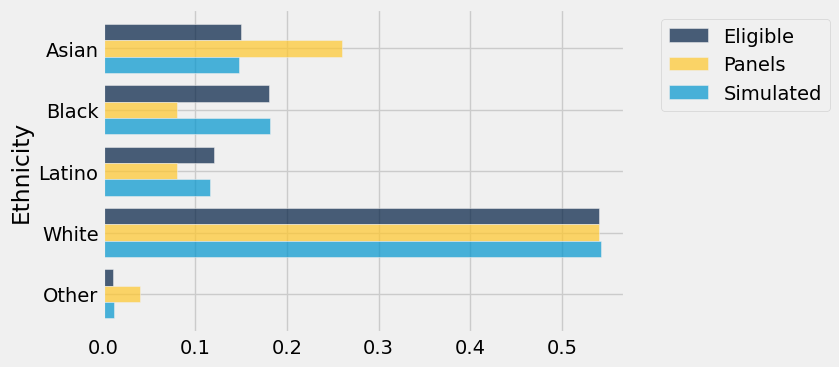

In [22]:
jury_with_simulated.barh('Ethnicity')

## Distance Between Distributions

In [23]:
# In this case, we need to understand how each of the 5 categories
# differ from their expected values according to the model.

diffs = jury.column('Panels') - jury.column('Eligible')
jury_with_difference = jury.with_column('Difference', diffs)
jury_with_difference

Ethnicity,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


## Total Variation Distance

In [24]:
def tvd(dist1, dist2):
    return sum(abs(dist1 - dist2))/2

In [25]:
# The TVD of our observed data (Panels) from their expected values
# assuming the model is true (Eligbible)
obsvd_tvd = tvd(jury.column('Panels'), jury.column('Eligible'))
obsvd_tvd

0.14000000000000001

In [26]:
# The TVD of a model simluation from its expected values
tvd(sample_proportions(1423, model), jury.column('Eligible'))

0.011820098383696423

In [27]:
def simulated_tvd():
    return tvd(sample_proportions(1423, model), model)

tvds = make_array()

num_simulations = 10000
for i in np.arange(num_simulations):
    new_tvd = simulated_tvd()
    tvds = np.append(tvds, new_tvd)

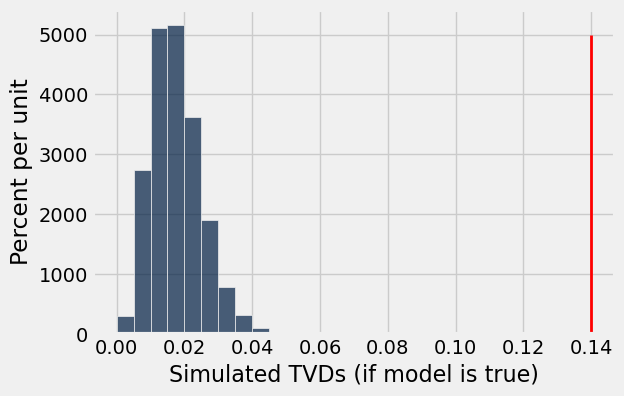

In [28]:
title = 'Simulated TVDs (if model is true)'
bins = np.arange(0, .05, .005)

Table().with_column(title, tvds).hist(bins = bins)
plots.plot([obsvd_tvd, obsvd_tvd], [0, 50], color='red', lw=2);

## Example: Benford's Law

In [29]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)

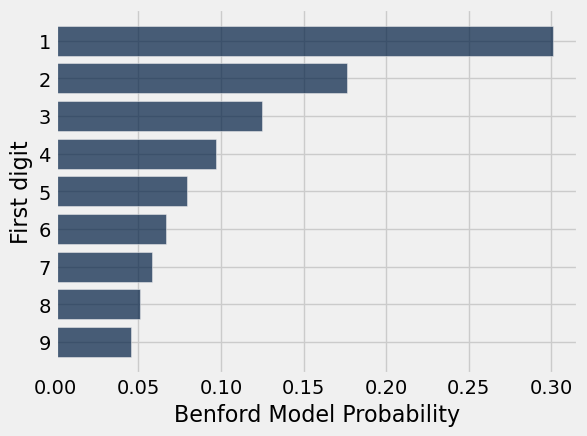

In [30]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford Model Probability', benford_model)
benford.barh('First digit')

In [31]:
# You don't have to understand how this function works, 
# since it uses Python features from beyond STOR 120.
def first_digit(num):
    return int(str(num)[0])

In [32]:
first_digit(32)

3

In [33]:
first_digit(17719087)

1

### Benford's Law and COVID-19 Reporting

In [34]:
COVID_by_digit = Table().with_columns(
    'First Digit', np.arange(1, 10),
    "Count", make_array(194, 106, 72, 51, 52, 38, 36, 22, 10)
)

COVID_by_digit

First Digit,Count
1,194
2,106
3,72
4,51
5,52
6,38
7,36
8,22
9,10


In [35]:
COVID_by_digit = COVID_by_digit.with_column(
    'Proportion', COVID_by_digit.column('Count') / sum(COVID_by_digit.column('Count'))
)

COVID_by_digit

First Digit,Count,Proportion
1,194,0.333907
2,106,0.182444
3,72,0.123924
4,51,0.0877797
5,52,0.0895009
6,38,0.0654045
7,36,0.0619621
8,22,0.0378657
9,10,0.0172117


In [36]:
COVID_observed_tvd = sum(abs(COVID_by_digit.column('Proportion') - benford_model))/2
COVID_observed_tvd

0.053519665852272122

In [37]:
def simulate_COVID_count_first_digits():
    simulated_frequencies = sample_proportions(sum(COVID_by_digit.column('Count')), benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [38]:
simulate_COVID_count_first_digits()

0.048846151931001038

In [39]:
COVID_simulated_tvds = make_array()

for i in np.arange(10000):
    COVID_simulated_tvds = np.append(COVID_simulated_tvds, simulate_COVID_count_first_digits())

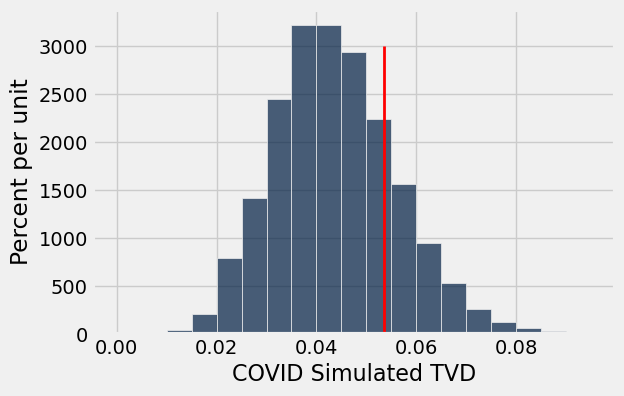

In [40]:
COVID_bins = np.arange(0, 0.10, 0.005)

Table().with_column('COVID Simulated TVD', COVID_simulated_tvds).hist(0, bins = COVID_bins)
plots.plot([COVID_observed_tvd, COVID_observed_tvd], [0, 30], color='red', lw=2);

In [41]:
np.count_nonzero(COVID_simulated_tvds >= COVID_observed_tvd) / 10000

0.2046